## Preprocesamiento del cubo
- Se usa la librería Pillow para sacar los valores RGB que se encuentran en cada celda de las imágenes del cubo extraidas de [este sitio web](https://rubikscu.be/).
- Librería numpy para el uso de funciones de arrays bidimensionales.
- Librería copy para evitar asignaciones por referencia.
- Librería re para formato del texto de salida.

54


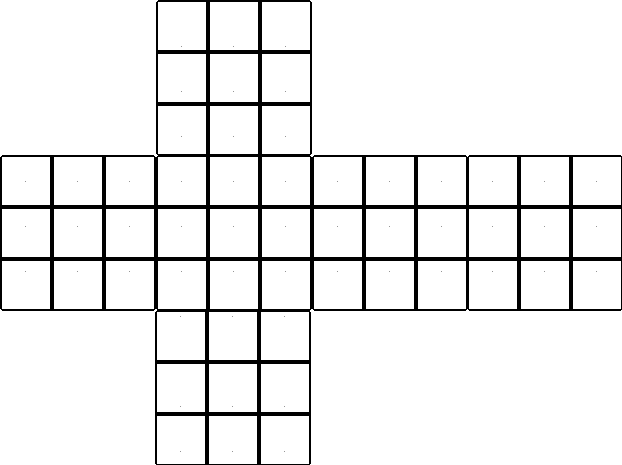

In [19]:
from PIL import Image, ImageOps
import numpy as np
import copy
import re

i1 = Image.open('Images\scrambled1.png')
i1_m = np.array(i1) # Matriz de imagen a color
i2 = ImageOps.grayscale(i1)
i2_m = np.array(i2) # Matriz de imagen a escala de grises

# Colorea todo lo que no sea borde a blanco y los bordes a negro
for i in range(len(i2_m)):
    for j in range(len(i2_m[i])):
        if i2_m[i][j] > 50:
            i2_m[i][j] = 255
        else:
            i2_m[i][j] = 0

edges = [[(i, j) for j in range(len(i2_m[i])) if i2_m[i][j] == 0] for i in range(len(i2_m))] # Posiciones de los bordes

# Obtención de los margenes del cubo de la imagen
top, bottom, left, right = len(i2_m), 0, len(i2_m[0]), 0
for i in edges:
    for j in i:
        if j[0] < top: top = j[0]
        if j[0] > bottom: bottom = j[0]
        if j[1] < left: left = j[1]
        if j[1] > right: right = j[1]

# Recorte de las imagenes
i2_m = i2_m[top:bottom, left:right]
i1_m = i1_m[top:bottom, left:right]

# Extracción del color de cada celda del cubo
count = 0
c = 0
colors = [] # Los colores aparecen en orden de izquierda a derecha y luego de arriba a abajo
for i in range(1, len(i2_m), 45):
    for j in range(len(i2_m[i])):
        if i2_m[i][j] == 255:
            count += 1
        elif count < 55 and count > 5:
            i2_m[i][j-25] = 150 # Para revisar los pixeles tomados
            colors.append(i1_m[i][j-25])
            count = 0
            c += 1
        else:
            count = 0
    count = 0

print(len(colors)) # Para ver que el número de colores sea correcto
i2 = Image.fromarray(i2_m) # Solo para ver los puntos de donde se sacó el color
i2

## Estructura del cubo
Se crea una clase *cube* que consiste principalmente de 6 objetos *_cube_face* enlazados que representan las caras del cubo. Los objetos *_cube_face* cuentan cada uno con una matriz 3*3 númerica, un nombre, y 4 atributos de direccionamiento para representar a sus vecinos inmediatos; estos objetos cuentan a su vez con funciones de movimiento que alteran sus valores para representar los movimientos en dirección del reloj y a contrarreloj de las caras.

In [20]:
class cube:
    """
    Clase cubo que contiene 6 objetos _cube_face que corresponden a las caras del cubo.
    """
    class _cube_face:
        """
        Clase representativa de la cara de un cubo que contiene 9 celdas.
        """

        def __init__(self, name):
            """
            Constructor de la cara, con 1 array bidimensional 3x3 y 4 atributos usados para referenciar las caras vecinas.

            Attributes:
                matrix (numpy.ndarray)
                up (Nonetype): Vecino encima.
                down (Nonetype): Vecino debajo.
                left (Nonetype): Vecino a la izquierda.
                right (Nonetype): Vecino a la derecha.
            """
            self.name = name
            self.matrix = np.zeros((3, 3))
            self.weight = np.zeros((3, 3))
            self.up = None
            self.down = None
            self.left = None
            self.right = None
            

        def links(self, up, down, left, right):
            """
            Función que enlaza las caras vecinas de una respectiva cara.

            Args:
                up (_cube_face): Vecino encima.
                down (_cube_face): Vecino debajo.
                left (_cube_face): Vecino a la izquierda.
                right (_cube_face): Vecino a la derecha.

            Attributes:
                up (_cube_face): Vecino encima.
                down (_cube_face): Vecino debajo.
                left (_cube_face): Vecino a la izquierda.
                right (_cube_face): Vecino a la derecha.
            """
            self.up = up
            self.down = down
            self.left = left
            self.right = right

        def _clock_reassign(self):
            """
            Función privada asignadora de valores de manera a favor del reloj.
            """
            temp = copy.copy(self.right.matrix[:,0][::-1]) # copy.copy es para evitar se asigne una referencia. El valor es invertido.
            self.right.matrix[:,[0]] = np.array([self.up.matrix[2]]).T
            self.up.matrix[2] = self.left.matrix[:,2][::-1] # El valor es invertido.
            self.left.matrix[:,[2]] = np.array([self.down.matrix[0]]).T
            self.down.matrix[0] = temp

        def _counter_reassign(self):
            """
            Función privada asignadora de valores de manera contrarreloj.
            """
            temp = copy.copy(self.left.matrix[:,2])
            self.left.matrix[:,[2]] = np.array([self.up.matrix[2][::-1]]).T
            self.up.matrix[2] = self.right.matrix[:,0]
            self.right.matrix[:,[0]] = np.array([self.down.matrix[0][::-1]]).T
            self.down.matrix[0] = temp

        def clockwise(self):
            """
            Rotación a favor del reloj a partir de una cara.
            """
            # Rotación de la matriz de la cara.
            self.matrix = np.rot90(self.matrix, axes=(1, 0))

            # Intercambio de valores entre los vecinos dependiendo de la cara.
            match self.name:
                case 'F':
                    self._clock_reassign()
                case 'R':
                    self.up.matrix = np.rot90(self.up.matrix, k = 1, axes=(1,0))
                    self.down.matrix = np.rot90(self.down.matrix, k = 1, axes=(0,1))
                    self._clock_reassign()
                    self.up.matrix = np.rot90(self.up.matrix, k = 1, axes=(0,1))
                    self.down.matrix = np.rot90(self.down.matrix, k = 1, axes=(1,0))                    
                case 'B':
                    self.up.matrix = np.rot90(self.up.matrix, k = 2, axes=(1,0))
                    self.down.matrix = np.rot90(self.down.matrix, k = 2, axes=(0,1))
                    self._clock_reassign()
                    self.up.matrix = np.rot90(self.up.matrix, k = 2, axes=(0,1))
                    self.down.matrix = np.rot90(self.down.matrix, k = 2, axes=(1,0))
                case 'L':
                    self.up.matrix = np.rot90(self.up.matrix, k = 1, axes=(0,1))
                    self.down.matrix = np.rot90(self.down.matrix, k = 1, axes=(1,0))
                    self._clock_reassign()
                    self.up.matrix = np.rot90(self.up.matrix, k = 1, axes=(1,0))
                    self.down.matrix = np.rot90(self.down.matrix, k = 1, axes=(0,1))   
                case 'U':
                    self.right.matrix = np.rot90(self.right.matrix, k = 1, axes=(0,1))
                    self.up.matrix = np.rot90(self.up.matrix, k = 2, axes=(0,1))
                    self.left.matrix = np.rot90(self.left.matrix, k = 1, axes=(1,0))
                    self._counter_reassign()
                    self.right.matrix = np.rot90(self.right.matrix, k = 1, axes=(1,0))
                    self.up.matrix = np.rot90(self.up.matrix, k = 2, axes=(1,0))
                    self.left.matrix = np.rot90(self.left.matrix, k = 1, axes=(0,1))
                case 'D':
                    self.right.matrix = np.rot90(self.right.matrix, k = 1, axes=(1,0))
                    self.down.matrix = np.rot90(self.down.matrix, k = 2, axes=(1,0))
                    self.left.matrix = np.rot90(self.left.matrix, k = 1, axes=(0,1))
                    self._counter_reassign()
                    self.right.matrix = np.rot90(self.right.matrix, k = 1, axes=(0,1))
                    self.down.matrix = np.rot90(self.down.matrix, k = 2, axes=(0,1))
                    self.left.matrix = np.rot90(self.left.matrix, k = 1, axes=(1,0))


        def counterclockwise(self):
            """
            Rotación contrarreloj a partir de una cara
            """

            # Rotación de la matriz de la cara.
            self.matrix = np.rot90(self.matrix, axes=(0, 1))

            # Intercambio de valores entre los vecinos dependiendo de la cara.
            match self.name:
                case 'F':
                    self._counter_reassign()
                case 'R':
                    self.up.matrix = np.rot90(self.up.matrix, k = 1, axes=(1,0))
                    self.down.matrix = np.rot90(self.down.matrix, k = 1, axes=(0,1))
                    self._counter_reassign()
                    self.up.matrix = np.rot90(self.up.matrix, k = 1, axes=(0,1))
                    self.down.matrix = np.rot90(self.down.matrix, k = 1, axes=(1,0))                    
                case 'B':
                    self.up.matrix = np.rot90(self.up.matrix, k = 2, axes=(1,0))
                    self.down.matrix = np.rot90(self.down.matrix, k = 2, axes=(0,1))
                    self._counter_reassign()
                    self.up.matrix = np.rot90(self.up.matrix, k = 2, axes=(0,1))
                    self.down.matrix = np.rot90(self.down.matrix, k = 2, axes=(1,0))
                case 'L':
                    self.up.matrix = np.rot90(self.up.matrix, k = 1, axes=(0,1))
                    self.down.matrix = np.rot90(self.down.matrix, k = 1, axes=(1,0))
                    self._counter_reassign()
                    self.up.matrix = np.rot90(self.up.matrix, k = 1, axes=(1,0))
                    self.down.matrix = np.rot90(self.down.matrix, k = 1, axes=(0,1))   
                case 'U':
                    self.right.matrix = np.rot90(self.right.matrix, k = 1, axes=(0,1))
                    self.up.matrix = np.rot90(self.up.matrix, k = 2, axes=(0,1))
                    self.left.matrix = np.rot90(self.left.matrix, k = 1, axes=(1,0))
                    self._clock_reassign()
                    self.right.matrix = np.rot90(self.right.matrix, k = 1, axes=(1,0))
                    self.up.matrix = np.rot90(self.up.matrix, k = 2, axes=(1,0))
                    self.left.matrix = np.rot90(self.left.matrix, k = 1, axes=(0,1))
                case 'D':
                    self.right.matrix = np.rot90(self.right.matrix, k = 1, axes=(1,0))
                    self.down.matrix = np.rot90(self.down.matrix, k = 2, axes=(1,0))
                    self.left.matrix = np.rot90(self.left.matrix, k = 1, axes=(0,1))
                    self._clock_reassign()
                    self.right.matrix = np.rot90(self.right.matrix, k = 1, axes=(0,1))
                    self.down.matrix = np.rot90(self.down.matrix, k = 2, axes=(0,1))
                    self.left.matrix = np.rot90(self.left.matrix, k = 1, axes=(1,0))


    def __init__(self):
        """
        Constructor del cubo, genera las 6 caras y las enlaza con sus respectivas vecinas.

        Attributes:
            F (_cube_face): Cara frontal (front).
            R (_cube_face): Cara derecha (right).
            B (_cube_face): Cara trasera (back).
            L (_cube_face): Cara izquierda (left).
            U (_cube_face): Cara superior (up).
            D (_cube_face): Cara inferior (down).
        """
        self.F = self._cube_face('F')
        self.R = self._cube_face('R')
        self.B = self._cube_face('B')
        self.L = self._cube_face('L')
        self.U = self._cube_face('U')
        self.D = self._cube_face('D')
        self.faces = [self.U, self.L, self.F, self.R, self.B, self.D] # Esto sirve de ayuda para llenar las matrices
        
        self.F.links(self.U, self.D, self.L, self.R)
        self.R.links(self.U, self.D, self.F, self.B)
        self.B.links(self.U, self.D, self.R, self.L)
        self.L.links(self.U, self.D, self.B, self.F)
        self.U.links(self.B, self.F, self.R, self.L)
        self.D.links(self.F, self.B, self.R, self.L)

    def show(self):
        """
        Muestra en consola el estado actual del cubo.
        """
        # Las caras unidas horizontalmente.
        middle_line = (self.L.matrix, self.F.matrix, self.R.matrix, self.B.matrix)
        # Las caras concatenadas en una sola matriz.
        middle = np.concatenate(middle_line, axis=1)

        # Formateando el texto.
        text = '\t  ' + f' {self.U.matrix}'.replace('\n', '\n\t  ')
        text += '\n\t   ' + '-------\n'
        for row in middle:
            for i in range(len(row)):
                text += f'{np.format_float_positional(row[i], precision=0)} '
                if ((i+1)%3 == 0 and (i+1 != len(row))):
                    text += f'| '
            text += '\n'
        text += '\t   -------'
        text += '\n\t  ' + f' {self.D.matrix}'.replace('\n', '\n\t  ')
        text = re.sub('\[|\]', '', text)
        print(text)

    def weights(self):
        pass

## Llenado de las matrices del cubo
Esta sección consiste en usar los colores obtenidos de la imagen y distribuirlos en las celdas respectivas del objeto *cube*, en este caso llamado "rubik". Las caras superior e inferior se asignan de manera consecutiva, mientras que para las caras de la línea central se hace uso de una función generadora para explorar las respectivas posiciones del cubo.

In [21]:
rubik = cube()
unique_col = np.unique(colors, axis=0)
col_nums = tuple(enumerate(unique_col))

# Llenado cara superior
nums = []
for i in colors[:9]:
    for count, item in col_nums:
        if (i == item).all():
            nums.append(count)

index = 0
for i in range(len(rubik.U.matrix)):
    for j in range(len(rubik.U.matrix[i])):
        rubik.U.matrix[i][j] = nums[index]
        index += 1

# Llenado caras centrales
nums = []
for i in colors[9:-9]:
    for count, item in col_nums:
        if (i == item).all():
            nums.append(count)
index = 2
ite=0
for i in range(len(rubik.F.matrix)):
    for j in range(len(rubik.F.matrix[i])):
        rubik.L.matrix[i][j] = nums[ite]
        rubik.F.matrix[i][j] = nums[ite+3]
        rubik.R.matrix[i][j] = nums[ite+6]
        rubik.B.matrix[i][j] = nums[ite+9]
        ite= int((520-1662*index+1645*index**2 -575*index**3 +75*index**4 -3*index**5)/(40*(23-10*index + index**2)))
        index += 1
        

# Llenado cara inferior
nums = []
for i in colors[-9:]:
    for count, item in col_nums:
        if (i == item).all():
            nums.append(count)

index = 0
for i in range(len(rubik.D.matrix)):
    for j in range(len(rubik.D.matrix[i])):
        rubik.D.matrix[i][j] = nums[index]
        index += 1

rubik.show()

	   4. 2. 3.
	   0. 5. 4.
	   5. 3. 0.
	   -------
2. 4. 2. | 1. 5. 2. | 5. 1. 0. | 5. 0. 1. 
5. 3. 2. | 5. 0. 2. | 1. 2. 3. | 4. 1. 0. 
2. 0. 1. | 3. 2. 0. | 4. 3. 1. | 5. 1. 0. 
	   -------
	   4. 4. 3.
	   3. 4. 1.
	   4. 5. 3.


In [22]:
def calculation(matrix,center,opposite,startrow,startcolumn):
  sumdistance=0
  for i in range(startrow,startrow+3):
    for j in range(startcolumn,startcolumn+3):
      if(matrix[i][j]==opposite):
        sumdistance=sumdistance+2
      else:
         if(matrix[i][j]!=center):
           sumdistance=sumdistance+1
  return sumdistance

In [23]:
def fcalculation (matrix):
  Distance=np.zeros((6,9))
  TotalDistance=0
  Distance[0:3,0:3]=matrix.F.matrix
  Distance[0:3,3:6]=matrix.R.matrix
  Distance[0:3,6:9]=matrix.L.matrix
  Distance[3:6,0:3]=matrix.U.matrix
  Distance[3:6,3:6]=matrix.D.matrix
  Distance[3:6,6:9]=matrix.B.matrix
  TotalDistance=TotalDistance+calculation(Distance,matrix.F.matrix[1][1],matrix.B.matrix[1][1],0,0)
  TotalDistance=TotalDistance+calculation(Distance,matrix.R.matrix[1][1],matrix.L.matrix[1][1],0,3)
  TotalDistance=TotalDistance+calculation(Distance,matrix.L.matrix[1][1],matrix.R.matrix[1][1],0,6)
  TotalDistance=TotalDistance+calculation(Distance,matrix.U.matrix[1][1],matrix.D.matrix[1][1],3,0)
  TotalDistance=TotalDistance+calculation(Distance,matrix.D.matrix[1][1],matrix.U.matrix[1][1],3,3)
  TotalDistance=TotalDistance+calculation(Distance,matrix.B.matrix[1][1],matrix.F.matrix[1][1],3,6)
  return TotalDistance

In [24]:
def expand (matrix,list,dist,indice0):
  temp=copy.deepcopy(matrix)
  temp.F.clockwise()
  
  list.insert(indice0,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])

  temp=copy.deepcopy(matrix)
  temp.F.counterclockwise()
  
  list.insert(indice0+1,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])


  temp=copy.deepcopy(matrix)
  temp.R.clockwise()
 
  list.insert(indice0+2,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])


  temp=copy.deepcopy(matrix)
  temp.R.counterclockwise()
  
  list.insert(indice0+3,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])


  temp=copy.deepcopy(matrix)
  temp.L.clockwise()
  
  list.insert(indice0+4,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])

  temp=copy.deepcopy(matrix)
  temp.L.counterclockwise()
  
  list.insert(indice0+5,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])
  temp=copy.deepcopy(matrix)
  temp.U.clockwise()
  
  list.insert(indice0+6,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])

  temp=copy.deepcopy(matrix)
  temp.U.counterclockwise()
  
  list.insert(indice0+7,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])

  temp=copy.deepcopy(matrix)
  temp.D.clockwise()
  
  list.insert(indice0+8,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])

  temp=copy.deepcopy(matrix)
  temp.D.counterclockwise()
  
  list.insert(indice0+9,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])

  temp=copy.deepcopy(matrix)
  temp.B.clockwise()
  
  list.insert(indice0+10,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])

  temp=copy.deepcopy(matrix)
  temp.B.counterclockwise()
  
  list.insert(indice0+11,[fcalculation(temp),fcalculation(temp)+dist,dist+1,temp])

  temp=copy.deepcopy(matrix)
  

In [25]:
routes = []
expand(rubik,routes,0,0)
routes

[[55, 55, 1, <__main__.cube at 0x299483c1db0>],
 [55, 55, 1, <__main__.cube at 0x29947a6ea10>],
 [57, 57, 1, <__main__.cube at 0x29947837160>],
 [51, 51, 1, <__main__.cube at 0x29949d19cc0>],
 [54, 54, 1, <__main__.cube at 0x29947dc45b0>],
 [54, 54, 1, <__main__.cube at 0x299483c29e0>],
 [52, 52, 1, <__main__.cube at 0x299483c2d10>],
 [50, 50, 1, <__main__.cube at 0x299483c0af0>],
 [52, 52, 1, <__main__.cube at 0x299483c2ad0>],
 [54, 54, 1, <__main__.cube at 0x299483c3340>],
 [52, 52, 1, <__main__.cube at 0x299483c22c0>],
 [48, 48, 1, <__main__.cube at 0x299483c2920>]]

In [26]:
global solvedcube
found=False
option=[]

In [27]:
def BestOption (fullList):
  menor=100
  indice=0
  save=[]
  for i in range(len(fullList)):
    if(fullList[i][1]<menor):
      menor=copy.deepcopy(fullList[i][1])
      indice=copy.deepcopy(i)
    if(fullList[i][0]==0):
      menor=-1
      indice=copy.deepcopy(i)
  expand(fullList[indice][3],fullList,fullList[indice][2],indice+1)
  save=fullList[indice]
  del fullList[indice]
  return save
  
def SolutionCheck(row):
  if(row[0]==0):
    return True
  else:
    return False


In [28]:
print("ESTADO INICIAL")
rubik.show()
while(found==False):
  option=BestOption(routes)
  found=SolutionCheck(option)
  print("Decision")
  option[3].show()
  print("Costo",option[0])
  print(found)


ESTADO INICIAL
	   4. 2. 3.
	   0. 5. 4.
	   5. 3. 0.
	   -------
2. 4. 2. | 1. 5. 2. | 5. 1. 0. | 5. 0. 1. 
5. 3. 2. | 5. 0. 2. | 1. 2. 3. | 4. 1. 0. 
2. 0. 1. | 3. 2. 0. | 4. 3. 1. | 5. 1. 0. 
	   -------
	   4. 4. 3.
	   3. 4. 1.
	   4. 5. 3.
Decision
	   2. 5. 2.
	   0. 5. 4.
	   5. 3. 0.
	   -------
4. 4. 2. | 1. 5. 2. | 5. 1. 4. | 1. 0. 0. 
5. 3. 2. | 5. 0. 2. | 1. 2. 2. | 0. 1. 1. 
3. 0. 1. | 3. 2. 0. | 4. 3. 3. | 5. 4. 5. 
	   -------
	   4. 4. 3.
	   3. 4. 1.
	   1. 3. 0.
Costo 48
False
Decision
	   2. 4. 0.
	   5. 5. 3.
	   2. 0. 5.
	   -------
1. 0. 0. | 4. 4. 2. | 1. 5. 2. | 5. 1. 4. 
5. 3. 2. | 5. 0. 2. | 1. 2. 2. | 0. 1. 1. 
3. 0. 1. | 3. 2. 0. | 4. 3. 3. | 5. 4. 5. 
	   -------
	   4. 4. 3.
	   3. 4. 1.
	   1. 3. 0.
Costo 43
False
Decision
	   2. 4. 5.
	   5. 5. 0.
	   2. 0. 5.
	   -------
1. 0. 0. | 4. 4. 0. | 2. 2. 3. | 0. 1. 4. 
5. 3. 2. | 5. 0. 3. | 5. 2. 3. | 1. 1. 1. 
3. 0. 1. | 3. 2. 5. | 1. 1. 4. | 3. 4. 5. 
	   -------
	   4. 4. 2.
	   3. 4. 2.
	   1. 3. 0.
Cost

KeyboardInterrupt: 